# Tutorial 7: Setup -- Policy Constraints

As show in previous tutorials, the settings file can be changed to adapt to a number of different systems. In Tutorial 3, we discussed how the setting Time Domain Reduction can reduce the computation time of the solver. Other settings, however, directly impact the values of the solution itself. This tutorial goes over the policy attributes in the settings and shows how implementing certain policies affects the optimal solution in GenX. To demonstrate these effects, we will be using `example_systems/1_three_zones`.

## Table of Contents
* [No Policy Constraints](#NoPolicies)
* [CO$_2$ Cap](#CO2Cap)
    * [Mass Cap](#MassCap)
        * [Tolerance](#Tolerance)
        * [CO$_2$ Slack](#CO2Slack)
    * [Load-based Cap](#LoadCap)
    * [Generator-based Cap](#GenerateCap)
* [Energy Share Requirement](#ESR)
* [Capacity Reserve Margin](#CRM)
* [Minimum Capacity Requriement](#MCR)
* [All Together](#All)
        

## No Policy Constraints <a id="NoPolicies"></a>

In [1]:
using JuMP
using HiGHS
using GenX
using CSV
using DataFrames
using Plots
using StatsPlots

In [2]:
case = joinpath("example_systems/1_three_zones") 

genx_settings = GenX.get_settings_path(case, "genx_settings.yml");
writeoutput_settings = GenX.get_settings_path(case, "output_settings.yml")
setup = GenX.configure_settings(genx_settings,writeoutput_settings)

Configuring Settings


"example_systems/1_three_zones/settings"

The settings we'll focus on here are , `CO2Cap`, `EnergyShareRequirement`, `CapacityReserveMargin`, and `MinCapReq`. Each of these ensures that the environmental impact of the model is taken into account, and are therefore referred to as __policy settings__ . For more information on what each one does, see the <a href="https://genxproject.github.io/GenX/dev/policies/" target="_blank">documentation</a>.

In [3]:
println("MaxCapReq: ", setup["MaxCapReq"])
println("MinCapReq: ", setup["MinCapReq"])
println("CO2Cap: ", setup["CO2Cap"])
println("EnergyShareRequirement: ", setup["EnergyShareRequirement"])
println("CapacityReserveMargin: ", setup["CapacityReserveMargin"])

MaxCapReq: 0
MinCapReq: 1
CO2Cap: 2
EnergyShareRequirement: 0
CapacityReserveMargin: 0


`1_three_zones` uses `MinCapReq` and `CO2Cap`. For the purpose of this tutorial, we're going to set these back to zero to start.

In [4]:
setup["MinCapReq"] = 0
setup["CO2Cap"] = 0;

Now, we'll generate and solve the model using these results:

In [6]:
## Delte Previous TDR Results
if "TDR_results" in cd(readdir,case)
    rm(joinpath(case,"TDR_results"), recursive=true) 
end

### Create TDR_Results
TDRpath = joinpath(case, setup["TimeDomainReductionFolder"])
system_path = joinpath(case, setup["SystemFolder"])
settings_path = GenX.get_settings_path(case)

if setup["TimeDomainReduction"] == 1
    GenX.prevent_doubled_timedomainreduction(system_path)
    if !GenX.time_domain_reduced_files_exist(TDRpath)
        println("Clustering Time Series Data (Grouped)...")
        GenX.cluster_inputs(case, settings_path, setup)
    else
        println("Time Series Data Already Clustered.")
    end
end


Clustering Time Series Data (Grouped)...
Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.



Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
CSV Files Successfully Read In From example_systems/1_three_zones
Error: Geography Key 1 is invalid. Select `System' or `Zone'.


Dict{String, Any} with 9 entries:
  "RMSE"          => Dict("ME_NG"=>0.194607, "ME_onshore_wind_z3"=>0.31331, "De…
  "OutputDF"      => 1848×19 DataFrame…
  "ColToZoneMap"  => Dict("Demand_MW_z3"=>3, "CT_battery_z2"=>2, "MA_natural_ga…
  "ClusterObject" => KmeansResult{Matrix{Float64}, Float64, Int64}([-0.750039 1…
  "TDRsetup"      => Dict{Any, Any}("IterativelyAddPeriods"=>1, "ExtremePeriods…
  "Assignments"   => [1, 1, 1, 1, 2, 2, 2, 2, 3, 4  …  6, 5, 10, 10, 10, 10, 11…
  "InputDF"       => 1680×52 DataFrame…
  "Weights"       => [673.846, 842.308, 168.462, 673.846, 842.308, 1684.62, 842…
  "Centers"       => Any[4, 8, 9, 12, 17, 24, 27, 33, 39, 48, 49]

In [7]:
OPTIMIZER = GenX.configure_solver(settings_path,HiGHS.Optimizer);
inputs = GenX.load_inputs(setup, case)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
CSV Files Successfully Read In From example_systems/1_three_zones


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Dict{Any, Any} with 67 entries:
  "Z"                         => 3
  "LOSS_LINES"                => [1, 2]
  "STOR_HYDRO_SHORT_DURATION" => Int64[]
  "RET_CAP_CHARGE"            => Set{Int64}()
  "pC_D_Curtail"              => [50.0, 45.0, 27.5, 10.0]
  "pTrans_Max_Possible"       => [5.9, 4.0]
  "pNet_Map"                  => [1.0 -1.0 0.0; 1.0 0.0 -1.0]
  "omega"                     => [4.01099, 4.01099, 4.01099, 4.01099, 4.01099, …
  "pMax_Line_Reinforcement"   => [2.95, 2.0]
  "RET_CAP_ENERGY"            => Int64[]
  "RESOURCES"                 => AbstractResource[…
  "COMMIT"                    => [1, 2, 3]
  "pMax_D_Curtail"            => [1.0, 0.04, 0.024, 0.003]
  "STOR_ALL"                  => [8, 9, 10]
  "THERM_ALL"                 => [1, 2, 3]
  "REP_PERIOD"                => 11
  "PWFU_Num_Segments"         => 0
  "STOR_LONG_DURATION"        => Int64[]
  "THERM_COMMIT_PWFU"         => Int64[]
  "STOR_SYMMETRIC"            => [8, 9, 10]
  "VRE"                       => [4, 

In [8]:
EP = GenX.generate_model(setup,inputs,OPTIMIZER)

Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module


A JuMP Model
Minimization problem with:
Variables: 120136
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 35112 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97949 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 116439 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCFuelOut, eCFuelStart, eCNSE, eCStart, eCVa

In [9]:
GenX.solve_model(EP,setup)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
118134 rows, 81183 cols, 422772 nonzeros
110977 rows, 74026 cols, 423286 nonzeros
Presolve : Reductions: rows 110977(-42415); columns 74026(-46110); elements 423286(-47824)
Solving the presolved LP
IPX model has 110977 rows, 74026 columns and 423286 nonzeros
Input
    Number of variables:                                74026
    Number of free variables:                           3696
    Number of constraints:                              110977
    Number of equality constraints:                     16867
    Number of matrix entries:                           423286
    Matrix range:                                       [4e-07, 1e+01]
    RHS range:                                          [8e-01, 1e+01]
    Objective range:                                    [1e-04, 5e+02]
    Bounds range:                                       [2e-03, 1e+01]
Preprocessing
    Dualized model:                    

(A JuMP Model
Minimization problem with:
Variables: 120136
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 35112 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97949 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 116439 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCFuelOut, eCFuelStart, eCNSE, eCStart, 

Using `value.()`, we can see what the total capacity is of the optimized model:

In [10]:
totCap_base = value.(EP[:eTotalCap])

10-element Vector{Float64}:
 10.618048905120226
 10.069915732863064
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.013752713744980789

Each element corresponds to the MW value of the node in the grid. In `1_three_zones`, there are ten nodes, each of which are either natural gas, wind, solar, or battery plants. We can see which is which using `Resource_Type`:

In [11]:
RT = inputs["RESOURCE_NAMES"];
DataFrame([RT totCap_base],["Resource","Total Capacity"])

Row,Resource,Total Capacity
,Any,Any
1,MA_natural_gas_combined_cycle,10.618
2,CT_natural_gas_combined_cycle,10.0699
3,ME_natural_gas_combined_cycle,0.0
4,MA_solar_pv,0.0
5,CT_onshore_wind,0.0
6,CT_solar_pv,0.0
7,ME_onshore_wind,0.0
8,MA_battery,0.0
9,CT_battery,0.0


To visualize the impact of the emmissions policies, let's group the nodes together by type and plot the data.

In [12]:
# Group by plant type
totCapB = [totCap_base[1] + totCap_base[2] + totCap_base[3], totCap_base[4] + totCap_base[6], 
    totCap_base[5] + totCap_base[7], totCap_base[8] + totCap_base[9] + totCap_base[10]]
totCapB = reshape(totCapB,(:,1)) # Convert to matrix

4×1 Matrix{Float64}:
 20.687964637983292
  0.0
  0.0
  0.013752713744980789

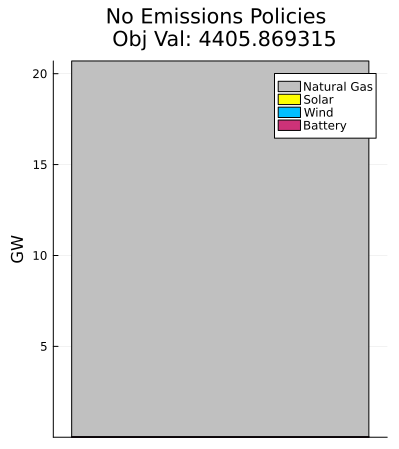

In [13]:
colors=[:silver :yellow :deepskyblue :violetred3]

G1 = groupedbar(transpose(totCapB), bar_position = :stack, bar_width=0.1,size=(400,450),
    labels=["Natural Gas" "Solar" "Wind" "Battery"],
    title="No Emissions Policies \n Obj Val: $(round(objective_value(EP),digits=6))",xticks=[ ],ylabel="GW",color=colors)

As you can see, with no limit on emissions, GenX goes straight to using natural gas. Let's try changing the settings to enforce emissions constraints.

## CO2 Cap <a id="CO2Cap"></a>

The setting <a href="https://genxproject.github.io/GenX/dev/policies/#CO_2-Constraint-Policy" target="_blank">`CO2Cap`</a> 
specifies if the model should have a constraint on CO$_2$ emmissions, and, if so, what that constraint should look like. There are three types, mass, load-based, and generator-based.

### Mass Cap <a id="MassCap"></a>

The first type of constraint, done by setting `CO2Cap` to "1", is a mass based constraint, which simply puts a limit on the total tons of CO$_2$ able to be produced per megawatt of electricty.

In [14]:
setup["CO2Cap"] = 1;

In [15]:
inputs = GenX.load_inputs(setup, case)
EP2 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP2,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From example_systems/1_three_zones
Discharge Module
Non-served Energy Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
118137 rows, 81183 cols, 433860 nonzeros
110718 rows, 73764 cols, 435402 nonzeros
Presolve : Reductions: rows 110718(-42677); columns 73764(-46375); elements 435402(-46799)
Solving the presolved LP
IPX model has 110718 rows, 73764 columns and 435402 nonzeros
Input
    Number of variables:                                73764
    Number of free variables:                           3696
    Number of constraints:                              110718
    Number of equality constraints:                     16605
    Number of matrix entries:      

(A JuMP Model
Minimization problem with:
Variables: 120139
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 35112 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97952 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 116439 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cCO2Emissions_systemwide, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCFuelOut, eC

In [16]:
totCap2 = value.(EP2[:eTotalCap])
totCapB2 = [totCap2[1] + totCap2[2] + totCap2[3], totCap2[4] + totCap2[6], 
    totCap2[5] + totCap2[7], totCap2[8] + totCap2[9] + totCap2[10]]

DataFrame([RT totCap2],["Resource Type","Total Capacity"])

Row,Resource Type,Total Capacity
,Any,Any
1,MA_natural_gas_combined_cycle,0.317743
2,CT_natural_gas_combined_cycle,0.471775
3,ME_natural_gas_combined_cycle,0.265972
4,MA_solar_pv,42.5666
5,CT_onshore_wind,0.0
6,CT_solar_pv,69.3198
7,ME_onshore_wind,7.14313
8,MA_battery,13.8304
9,CT_battery,28.968


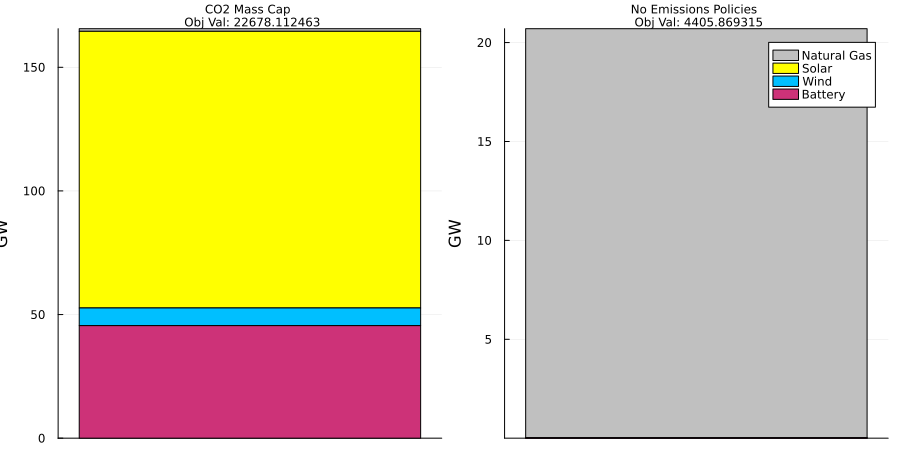

In [17]:
G2 = groupedbar(transpose(totCapB2), bar_position = :stack, bar_width=0.1,size=(100,450),
    labels=["Natural Gas" "Solar" "Wind" "Battery"],legend = false,title="CO2 Mass Cap \n Obj Val: $(round(objective_value(EP2),digits=6))",
xticks=[ ],ylabel="GW",color=colors)
plot(G2,G1,size=(900,450),titlefontsize=8)


The model favors solar power now, but natural gas and wind are also used. One thing to note is that the objective value of this system is much higher than it was without emissions constraints. The amount of CO$_2$ allowed is determined by the inputfile CO2_cap.csv:

In [18]:
CO2Cap =  CSV.read(joinpath(case,"policies/CO2_cap.csv"),DataFrame,missingstring="NA")

Row,Column1,Network_zones,CO_2_Cap_Zone_1,CO_2_Cap_Zone_2,CO_2_Cap_Zone_3,CO_2_Max_tons_MWh_1,CO_2_Max_tons_MWh_2,CO_2_Max_tons_MWh_3,CO_2_Max_Mtons_1,CO_2_Max_Mtons_2,CO_2_Max_Mtons_3
,String3,String3,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,MA,z1,1,0,0,0.05,0.0,0.0,0.018,0.0,0.0
2,CT,z2,0,1,0,0.0,0.05,0.0,0.0,0.025,0.0
3,ME,z3,0,0,1,0.0,0.0,0.05,0.0,0.0,0.025


#### Tolerance of Cap <a id="Tolerance"></a>

Let's try setting the CO$_2$ emissions tolerance to 0 for all nodes:

In [19]:
CO2Cap2 = copy(CO2Cap); # Save old tolerances

In [20]:
CO2Cap2[!,"CO_2_Max_tons_MWh_1"] = [0.0;0.0;0.0];
CO2Cap2[!,"CO_2_Max_tons_MWh_2"] = [0.0;0.0;0.0];
CO2Cap2[!,"CO_2_Max_tons_MWh_3"] = [0.0;0.0;0.0];
CO2Cap2[!,"CO_2_Max_Mtons_1"] = [0.0;0.0;0.0];
CO2Cap2[!,"CO_2_Max_Mtons_2"] = [0.0;0.0;0.0];
CO2Cap2[!,"CO_2_Max_Mtons_3"] = [0.0;0.0;0.0];

In [24]:
CSV.write(joinpath(case,"policies/CO2_cap.csv"),CO2Cap2)

"example_systems/1_three_zones/policies/CO2_cap.csv"

In [25]:
inputs = GenX.load_inputs(setup, case)
EP3 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP3,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From example_systems/1_three_zones
Discharge Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
62694 rows, 59004 cols, 206556 nonzeros
55729 rows, 52039 cols, 206282 nonzeros
Presolve : Reductions: rows 55729(-97666); columns 52039(-68100); elements 206282(-275919)
Solving the presolved LP
IPX model has 55729 rows, 52039 columns and 206282 nonzeros
Input
    Number of variables:                                52039
    Number of free variables:                           3696
    Number of constraints:                              55729
    Number of equality constraints:                     11515
    Number of 

(A JuMP Model
Minimization problem with:
Variables: 120139
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 35112 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97952 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 116439 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cCO2Emissions_systemwide, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCFuelOut, eC

10×2 DataFrame
 Row │ Resource Type                  Total Capacity 
     │ Any                            Any            
─────┼───────────────────────────────────────────────
   1 │ MA_natural_gas_combined_cycle  0.0
   2 │ CT_natural_gas_combined_cycle  0.0
   3 │ ME_natural_gas_combined_cycle  0.0
   4 │ MA_solar_pv                    43.6564
   5 │ CT_onshore_wind                0.0
   6 │ CT_solar_pv                    71.813
   7 │ ME_onshore_wind                5.45963
   8 │ MA_battery                     14.9902
   9 │ CT_battery                     30.3322
  10 │ ME_battery                     2.13298
 
Objective Value: 23752.09299025141


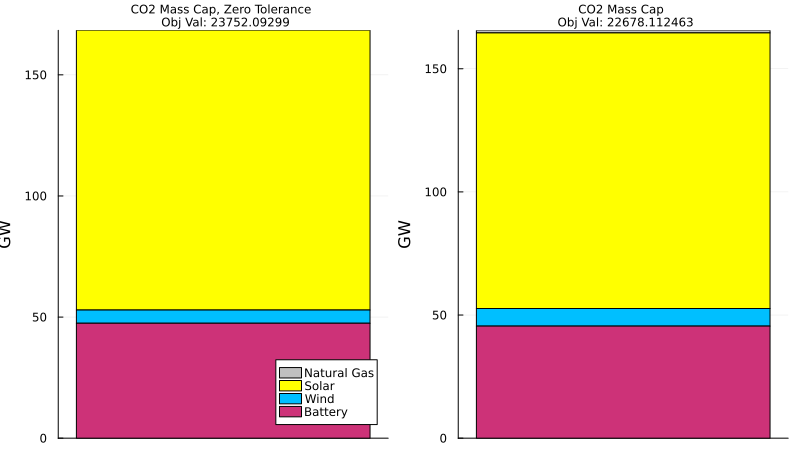

In [26]:
totCap3 = value.(EP3[:eTotalCap])

totCapB3 = [totCap3[1] + totCap3[2] + totCap3[3], totCap3[4] + totCap3[6], 
    totCap3[5] + totCap3[7], totCap3[8] + totCap3[9] + totCap3[10]]

println(DataFrame([RT totCap3],["Resource Type","Total Capacity"]))
println(" ")

println("Objective Value: ", objective_value(EP3))

G3 = groupedbar(transpose(totCapB3), bar_position = :stack, bar_width=0.1,size=(400,450), xticks=[ ],ylabel="GW",
    labels=["Natural Gas" "Solar" "Wind" "Battery"],color=colors,
    title="CO2 Mass Cap, Zero Tolerance \n Obj Val: $(round(objective_value(EP3),digits=6))")

plot(G3,G2,size=(800,450),titlefontsize=8)

As you can see, the use of natural gas has been eliminated compeltely. Note that the objective value increases here as well as renewable energy tends to cost more than natural gas.

#### CO$_2$ Slack Cap <a id="CO2Slack"></a>

Another thing we can do is, instead of demanding that the model 100% meet the CO$_2$ cap, we can add a penalty for if it violates the cap. This lets the system allow some CO$_2$ emmissions if it's determined the cost of the grid with some emmissions is low enough that it will offset the cost from the penalty variable. GenX will automatically incorporate this feature if a file by the name "CO2_cap_slack.csv" is in the policies folder of the directory. For more information on other types of policy slack variables in GenX, see the <a href="https://genxproject.github.io/GenX/dev/slack_variables_overview/#Policy-Slack-Variables" target="_blank">documentation</a>.

Here, the CO$_2$ slack cap models a <a href="https://en.wikipedia.org/wiki/Carbon_tax#:~:text=A%20carbon%20tax%20is%20a,like%20more%20severe%20weather%20events.of" target="_blank">carbon tax</a> \$250 per ton of emissions.

In [27]:
CO2Cap_slack = DataFrame(["CO_2_Cap_Zone_1" 250; "CO_2_Cap_Zone_2" 250; "CO_2_Cap_Zone_2" 250],["CO2_Cap_Constraint","PriceCap"])

Row,CO2_Cap_Constraint,PriceCap
,Any,Any
1,CO_2_Cap_Zone_1,250
2,CO_2_Cap_Zone_2,250
3,CO_2_Cap_Zone_2,250


In [28]:
CSV.write(joinpath(case,"policies/CO2_cap_slack.csv"),CO2Cap_slack)

"example_systems/1_three_zones/policies/CO2_cap_slack.csv"

And run it again,

In [29]:
inputs = GenX.load_inputs(setup, case)
EP4 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP4,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From example_systems/1_three_zones
Discharge Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
118134 rows, 81183 cols, 422772 nonzeros
110977 rows, 74026 cols, 423286 nonzeros
Presolve : Reductions: rows 110977(-42418); columns 74026(-46113); elements 423286(-58915)
Solving the presolved LP
IPX model has 110977 rows, 74026 columns and 423286 nonzeros
Input
    Number of variables:                                74026
    Number of free variables:                           3696
    Number of constraints:                              110977
    Number of equality constraints:                     16867
    Number

(A JuMP Model
Minimization problem with:
Variables: 120139
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 35112 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97952 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 116442 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cCO2Emissions_systemwide, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCCO2Cap_slack, eCFix, eCFixEnergy

In [30]:
value.(EP4[:eCTotalCO2CapSlack])

3134.305531123746

10×2 DataFrame
 Row │ Resource Type                  Total Capacity 
     │ Any                            Any            
─────┼───────────────────────────────────────────────
   1 │ MA_natural_gas_combined_cycle  5.72629
   2 │ CT_natural_gas_combined_cycle  7.94326
   3 │ ME_natural_gas_combined_cycle  0.0
   4 │ MA_solar_pv                    10.7951
   5 │ CT_onshore_wind                11.8345
   6 │ CT_solar_pv                    7.22352
   7 │ ME_onshore_wind                9.20972
   8 │ MA_battery                     1.77156
   9 │ CT_battery                     2.83506
  10 │ ME_battery                     0.631189
 
Objective Value: 10513.642873143204


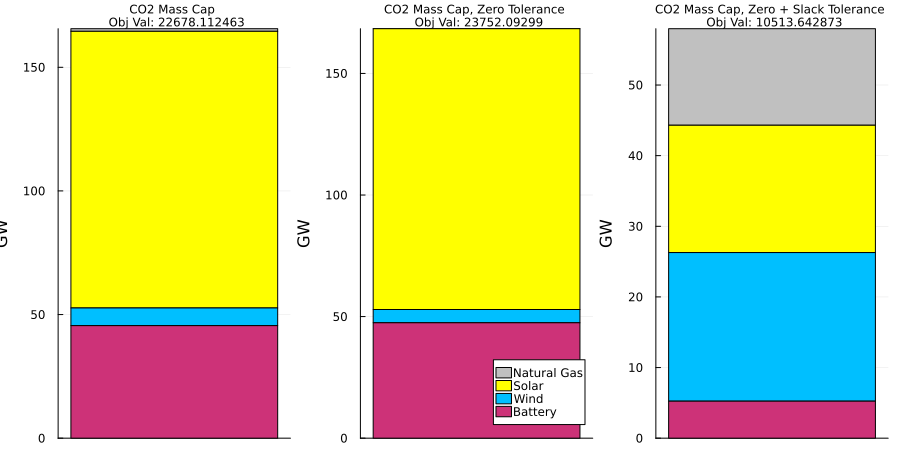

In [31]:
totCap4 = value.(EP4[:eTotalCap])

totCapB4 = [totCap4[1] + totCap4[2] + totCap4[3], totCap4[4] + totCap4[6], 
    totCap4[5] + totCap4[7], totCap4[8] + totCap4[9] + totCap4[10]]

println(DataFrame([RT totCap4],["Resource Type","Total Capacity"]))
println(" ")

println("Objective Value: ", objective_value(EP4))

G4 = groupedbar(transpose(totCapB4), bar_position = :stack, bar_width=0.1,size=(400,450), xticks=[ ],ylabel="GW",
    labels=["Natural Gas" "Solar" "Wind" "Battery"],legend=false,color=colors,
    title="CO2 Mass Cap, Zero + Slack Tolerance \n Obj Val: $(round(objective_value(EP4),digits=6))")

plot(G2,G3,G4,size=(900,450),layout=(1,3),titlefontsize=8)

Adding in the slack variables allowed for some natural gas to be used once again and decreased the overall cost (objective function).

###  Load + Rate-Based CO$_2$ Cap <a id="LoadCap"></a>

Another way to set the CO$_2$ emissions cap is to limit emissions as a function of the total demand in that region. This can be done by setting `CO2Cap` to "2" in the setup:

In [32]:
setup["CO2Cap"] = 2;

Let's set the CO2_cap.csv back to it's original data, and remove the slack cap:

In [34]:
rm(joinpath(case,"policies/CO2_cap_slack.csv"))
CSV.write(joinpath(case,"policies/CO2_cap.csv"),CO2Cap)

"example_systems/1_three_zones/policies/CO2_cap.csv"

In [35]:
inputs = GenX.load_inputs(setup, case)
EP5 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP5,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From example_systems/1_three_zones
Discharge Module
Non-served Energy Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
118137 rows, 81183 cols, 467124 nonzeros
110718 rows, 73764 cols, 468666 nonzeros
Presolve : Reductions: rows 110718(-42677); columns 73764(-46375); elements 468666(-46799)
Solving the presolved LP
IPX model has 110718 rows, 73764 columns and 468666 nonzeros
Input
    Number of variables:                                73764
    Number of free variables:                           3696
    Number of constraints:                              110718
    Number of equality constraints:                     16605
    Number of matrix entries:      

(A JuMP Model
Minimization problem with:
Variables: 120139
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 35112 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97952 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 116439 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cCO2Emissions_systemwide, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCFuelOut, eC

10×2 DataFrame
 Row │ Resource Type                  Total Capacity 
     │ Any                            Any            
─────┼───────────────────────────────────────────────
   1 │ MA_natural_gas_combined_cycle  7.80639
   2 │ CT_natural_gas_combined_cycle  2.30348
   3 │ ME_natural_gas_combined_cycle  0.657142
   4 │ MA_solar_pv                    17.2932
   5 │ CT_onshore_wind                15.8786
   6 │ CT_solar_pv                    13.8093
   7 │ ME_onshore_wind                11.7469
   8 │ MA_battery                     2.70912
   9 │ CT_battery                     6.15284
  10 │ ME_battery                     1.31651
 


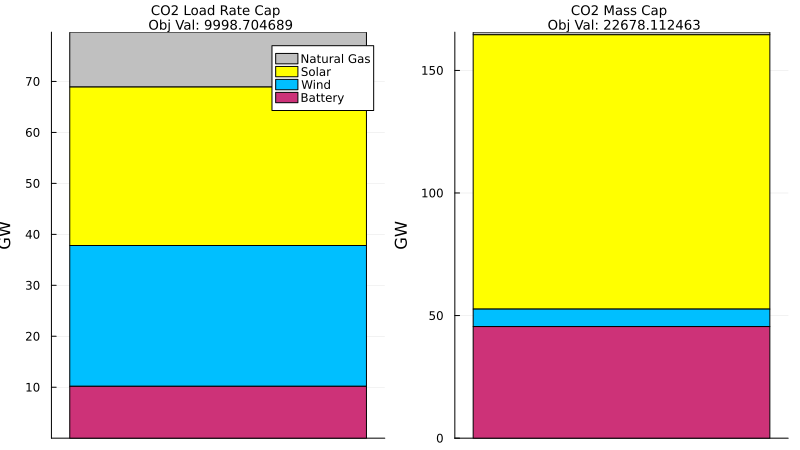

In [36]:
totCap5 = value.(EP5[:eTotalCap])

totCapB5 = [totCap5[1] + totCap5[2] + totCap5[3], totCap5[4] + totCap5[6], 
    totCap5[5] + totCap5[7], totCap5[8] + totCap5[9] + totCap5[10]]

toPlot = [transpose(totCapB2);transpose(totCapB5)]

println(DataFrame([RT totCap5],["Resource Type","Total Capacity"]))
println(" ")

G5 = groupedbar(transpose(totCapB5), bar_position = :stack, bar_width=.8,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],color=colors,
        title="CO2 Load Rate Cap \n Obj Val: $(round(objective_value(EP5),digits=6))")
plot(G5,G2,size=(800,450), titlefontsize=9)

### Generation + Rate-based CO$_2$ Cap <a id="GenerateCap"></a>

Finally, the third type of emissions cap in GenX is where the constraint is based on the ratio between the CO$_2$ cap and the generation of each node.

In [37]:
setup["CO2Cap"] = 3;

In [38]:
inputs = GenX.load_inputs(setup, case)
EP6 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP6,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From example_systems/1_three_zones
Discharge Module
Non-served Energy Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
118137 rows, 81183 cols, 439260 nonzeros
110718 rows, 73764 cols, 440802 nonzeros
Presolve : Reductions: rows 110718(-42677); columns 73764(-46375); elements 440802(-54335)
Solving the presolved LP
IPX model has 110718 rows, 73764 columns and 440802 nonzeros
Input
    Number of variables:                                73764
    Number of free variables:                           3696
    Number of constraints:                              110718
    Number of equality constraints:                     16605
    Number of matrix entries:      

(A JuMP Model
Minimization problem with:
Variables: 120139
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 35112 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97952 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 116439 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cCO2Emissions_systemwide, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCFuelOut, eC

10×2 DataFrame
 Row │ Resource Type                  Total Capacity 
     │ Any                            Any            
─────┼───────────────────────────────────────────────
   1 │ MA_natural_gas_combined_cycle  3.3454
   2 │ CT_natural_gas_combined_cycle  6.24691
   3 │ ME_natural_gas_combined_cycle  1.14562
   4 │ MA_solar_pv                    18.8685
   5 │ CT_onshore_wind                15.9665
   6 │ CT_solar_pv                    13.1419
   7 │ ME_onshore_wind                11.0922
   8 │ MA_battery                     2.81492
   9 │ CT_battery                     6.20133
  10 │ ME_battery                     1.28446
 


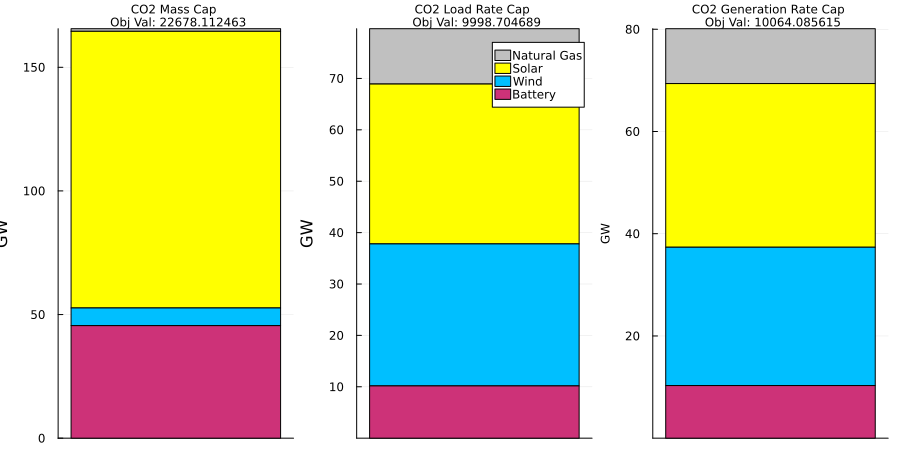

In [39]:
totCap6 = value.(EP6[:eTotalCap])

totCapB6 = [totCap6[1] + totCap6[2] + totCap6[3], totCap6[4] + totCap6[6], 
    totCap6[5] + totCap6[7], totCap6[8] + totCap6[9] + totCap6[10]]

println(DataFrame([RT totCap6],["Resource Type","Total Capacity"]))
println(" ")

G6 = groupedbar(transpose(totCapB6), bar_position = :stack, bar_width=.7,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],legend=false,color=colors,
        title="CO2 Generation Rate Cap \n Obj Val: $(round(objective_value(EP6),digits=6))",ylabelfontsize=8)
plot(G2,G5,G6,size=(900,450), titlefontsize=8,layout=(1,3),)

## Energy Share Requirement <a id="ESR"></a>

Many countries have policies that demand a certain percentage of energy provided to consumers comes from renewable energy (in the US, these are called <a href="https://www.eia.gov/energyexplained/renewable-sources/portfolio-standards.php#:~:text=Renewable%20portfolio%20standards%20(RPS)%2C,energy%20sources%20for%20electricity%20generation" target="_blank">renewable portfolio standards</a>.) In GenX, this policy can be implemented by setting `EnergyShareRequirement` to 1 in the setup.

In [40]:
ESR =  CSV.read(joinpath(case,"policies/Energy_share_requirement.csv"),DataFrame,missingstring="NA")

Row,Column1,Network_zones,ESR_1,ESR_2
,String3,String3,Float64,Float64
1,MA,z1,0.259,0.348
2,CT,z2,0.44,0.44
3,ME,z3,0.776,0.776


In [41]:
setup["CO2Cap"] = 0 # set back to 0 to compare
setup["EnergyShareRequirement"] = 1;

In [43]:
inputs = GenX.load_inputs(setup, case)
EP7 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP7,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.



Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Energy_share_requirement.csv Successfully Read!
CSV Files Successfully Read In From example_systems/1_three_zones
Discharge Module
Non-served Energy Module


[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
Energy Share Requirement Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
118136 rows, 81183 cols, 433572 nonzeros
110978 rows, 74026 cols, 428686 nonzeros
Presolve : Reductions: rows 110978(-42416); columns 74026(-46110); elements 428686(-57208)
Solving the presolved LP
IPX model has 110978 rows, 74026 columns and 428686 nonzeros
Input
    Number of variables:                                74026
    Number of free variables:                           3696
    Number of constraints:                              110978
    Number of equality constraints:                     16867
    Number of 

(A JuMP Model
Minimization problem with:
Variables: 120136
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 35112 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20333 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97949 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 116439 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cESRShare, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCFuelOut, eCFuelStart, eCNSE

10×2 DataFrame
 Row │ Resource Type                  Total Capacity 
     │ Any                            Any            
─────┼───────────────────────────────────────────────
   1 │ MA_natural_gas_combined_cycle  8.69065
   2 │ CT_natural_gas_combined_cycle  9.41678
   3 │ ME_natural_gas_combined_cycle  0.0
   4 │ MA_solar_pv                    2.61648
   5 │ CT_onshore_wind                5.93099
   6 │ CT_solar_pv                    0.0659987
   7 │ ME_onshore_wind                6.38894
   8 │ MA_battery                     0.405603
   9 │ CT_battery                     0.0
  10 │ ME_battery                     0.432665
 


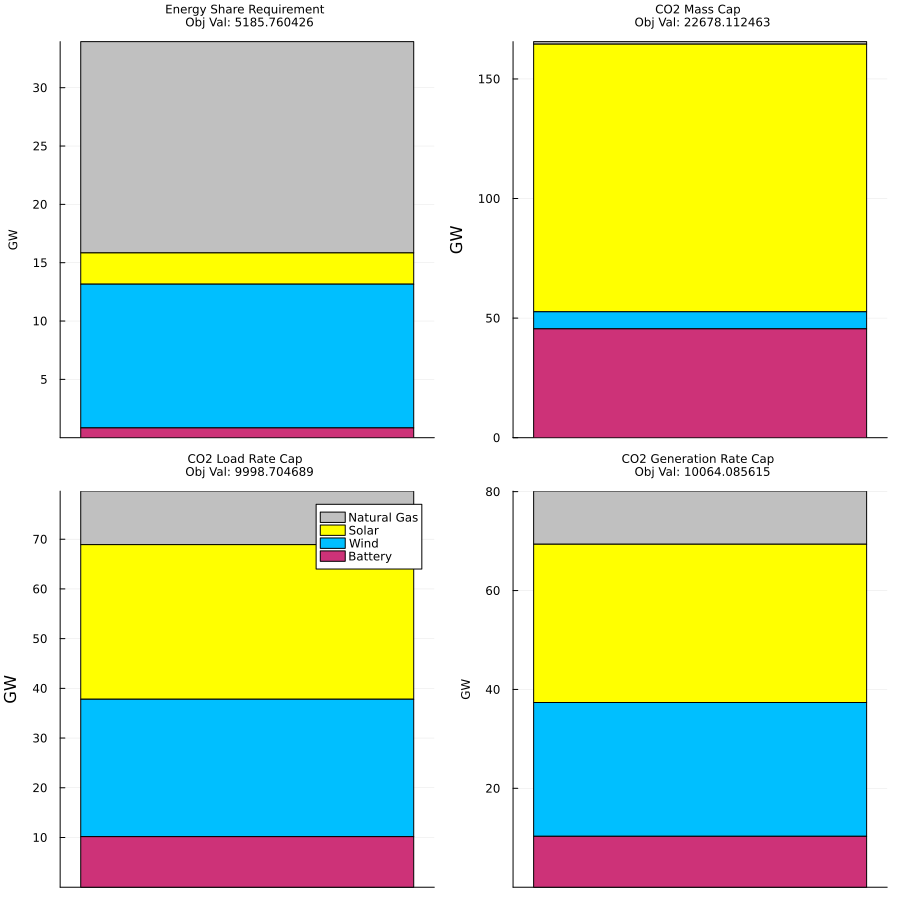

In [44]:
totCap7 = value.(EP7[:eTotalCap])

totCapB7 = [totCap7[1] + totCap7[2] + totCap7[3], totCap7[4] + totCap7[6], 
    totCap7[5] + totCap7[7], totCap7[8] + totCap7[9] + totCap7[10]]

println(DataFrame([RT totCap7],["Resource Type","Total Capacity"]))
println(" ")

G7 = groupedbar(transpose(totCapB7), bar_position = :stack, bar_width=.7,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],legend=false,color=colors,
        title="Energy Share Requirement \n Obj Val: $(round(objective_value(EP7),digits=6))",ylabelfontsize=8)
plot(G7,G2,G5,G6,size=(900,900), titlefontsize=8,layout=(2,2))

The Energy Share Requriement policy also has the possibiliy to be run with <a href="https://genxproject.github.io/GenX/dev/slack_variables_overview/#Policy-Slack-Variables" target="_blank">slack variables</a>.

## Capacity Reserve Margin <a id="CRM"></a>

The  <a href="https://genxproject.github.io/GenX/dev/policies/#Capacity-Reserve-Margin" target="_blank">Capacity Reserve Margin</a> constraint demands that a certain amount of energy always be available in each zone, expressed as a fraction of the demand.

In [45]:
CapacityReserve =  CSV.read(joinpath(case,"policies/Capacity_reserve_margin.csv"),DataFrame,missingstring="NA")

Row,Column1,Network_zones,CapRes_1
,String3,String3,Float64
1,MA,z1,0.156
2,CT,z2,0.156
3,ME,z3,0.156


In [46]:
setup["CapacityReserveMargin"] = 1;

In [47]:
inputs = GenX.load_inputs(setup, case)
EP8 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP8,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Capacity_reserve_margin.csv Successfully Read!


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Energy_share_requirement.csv Successfully Read!
CSV Files Successfully Read In From example_systems/1_three_zones
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
Energy Share Requirement Policies Module
Capacity Reserve Margin Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
131072 rows, 97815 cols, 538764 nonzeros
123613 rows, 90357 cols, 543032 nonzeros
Presolve : Reductions: rows 123613(-42717); columns 90357(-46411); elements 543032(-48054)
Solving the presolved LP
IPX model has 123613 rows, 90357 columns and 543032 nonzeros
Input
    Number of variables:                                90357
    

(A JuMP Model
Minimization problem with:
Variables: 136768
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 40656 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 27725 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97949 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 133071 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cCapacityResMargin, cESRShare, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSOCMinCapRes, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, cVSoCBalInterior, cVSoCBalStart,

10×2 DataFrame
 Row │ Resource Type                  Total Capacity 
     │ Any                            Any            
─────┼───────────────────────────────────────────────
   1 │ MA_natural_gas_combined_cycle  8.69037
   2 │ CT_natural_gas_combined_cycle  14.642
   3 │ ME_natural_gas_combined_cycle  0.0
   4 │ MA_solar_pv                    2.32148
   5 │ CT_onshore_wind                6.15099
   6 │ CT_solar_pv                    0.0
   7 │ ME_onshore_wind                6.34468
   8 │ MA_battery                     0.456214
   9 │ CT_battery                     0.0
  10 │ ME_battery                     0.357359
 


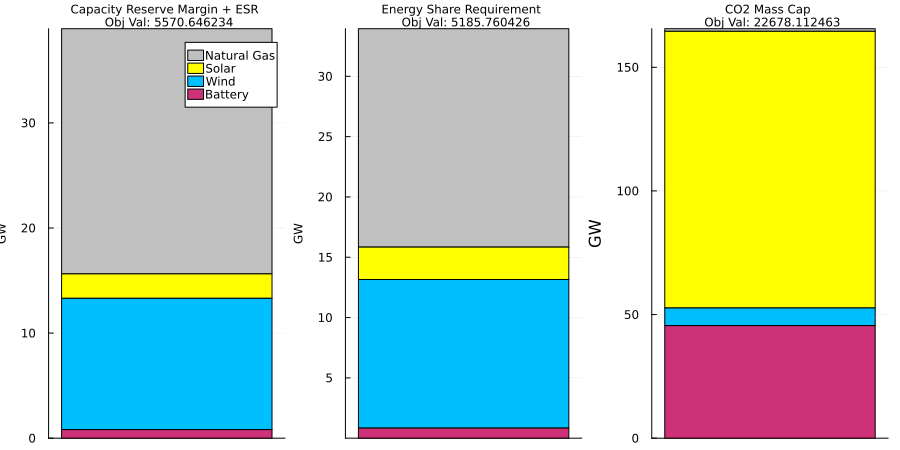

In [59]:
totCap8 = value.(EP8[:eTotalCap])

totCapB8 = [totCap8[1] + totCap8[2] + totCap8[3], totCap8[4] + totCap8[6], 
    totCap8[5] + totCap8[7], totCap8[8] + totCap8[9] + totCap8[10]]

println(DataFrame([RT totCap8],["Resource Type","Total Capacity"]))
println(" ")

G8 = groupedbar(transpose(totCapB8), bar_position = :stack, bar_width=.7,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],color=colors,
        title="Capacity Reserve Margin + ESR \n Obj Val: $(round(objective_value(EP8),digits=6))",ylabelfontsize=8)

plot(G8,G7,G2,size=(900,450), titlefontsize=8,layout=(1,3))

Capacity Reserve Margin also has the possibiliy to be run with <a href="https://genxproject.github.io/GenX/dev/slack_variables_overview/#Policy-Slack-Variables" target="_blank">slack variables</a>.

## Minimum Capacity Requirement <a id="MCR"></a>

The last policy we'll talk about is <a href="https://genxproject.github.io/GenX/dev/policies/#Minimum-Capacity-Requirement" target="_blank">Minimum Capacity</a>,  which requires the grid to produce at least a certain amount of energy from renewables, as specified in the input file:

In [49]:
MinCapacity =  CSV.read(joinpath(case,"policies/Minimum_capacity_requirement.csv"),DataFrame,missingstring="NA")

Row,MinCapReqConstraint,ConstraintDescription,Min_MW
,Int64,String15,Int64
1,1,MA_PV,5000
2,2,CT_Wind,10000
3,3,All_Batteries,6000


This policy ensures some renewable energy is used in the grid regardless of emissions constraints. If a fourth column containing price cap requirements exists (not shown above), that column is treated as a <a href="https://genxproject.github.io/GenX/dev/slack_variables_overview/#Minimum-Capacity-Requirement" target="_blank">slack variable</a>.

In [50]:
setup["CapacityReserveMargin"] = 0
setup["EnergyShareRequirement"] = 0
setup["MinCapReq"] = 1;

In [51]:
inputs = GenX.load_inputs(setup, case)
EP9 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP9,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Minimum_capacity_requirement.csv Successfully Read!
CSV Files Successfully Read In From example_systems/1_three_zones
Discharge Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
Minimum Capacity Requirement Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
118135 rows, 81183 cols, 422775 nonzeros
110978 rows, 74026 cols, 423289 nonzeros
Presolve : Reductions: rows 110978(-42417); columns 74026(-46110); elements 423289(-47826)
Solving the presolved LP
IPX model has 110978 rows, 74026 columns and 423289 nonzeros
Input
    Number of variables:                                74026
    Number of free variables:                           3696
    Number of constraints:                              110978
    Number of equality constraints:                     

(A JuMP Model
Minimization problem with:
Variables: 120136
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 35112 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20334 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97949 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 116439 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, cZoneMinCapReq, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCFuelOut, eCFuelStart, 

10×2 DataFrame
 Row │ Resource Type                  Total Capacity 
     │ Any                            Any            
─────┼───────────────────────────────────────────────
   1 │ MA_natural_gas_combined_cycle  9.09679
   2 │ CT_natural_gas_combined_cycle  8.65583
   3 │ ME_natural_gas_combined_cycle  0.0
   4 │ MA_solar_pv                    5.0
   5 │ CT_onshore_wind                10.0
   6 │ CT_solar_pv                    0.0
   7 │ ME_onshore_wind                0.0
   8 │ MA_battery                     0.0213956
   9 │ CT_battery                     4.00792
  10 │ ME_battery                     1.97069
 


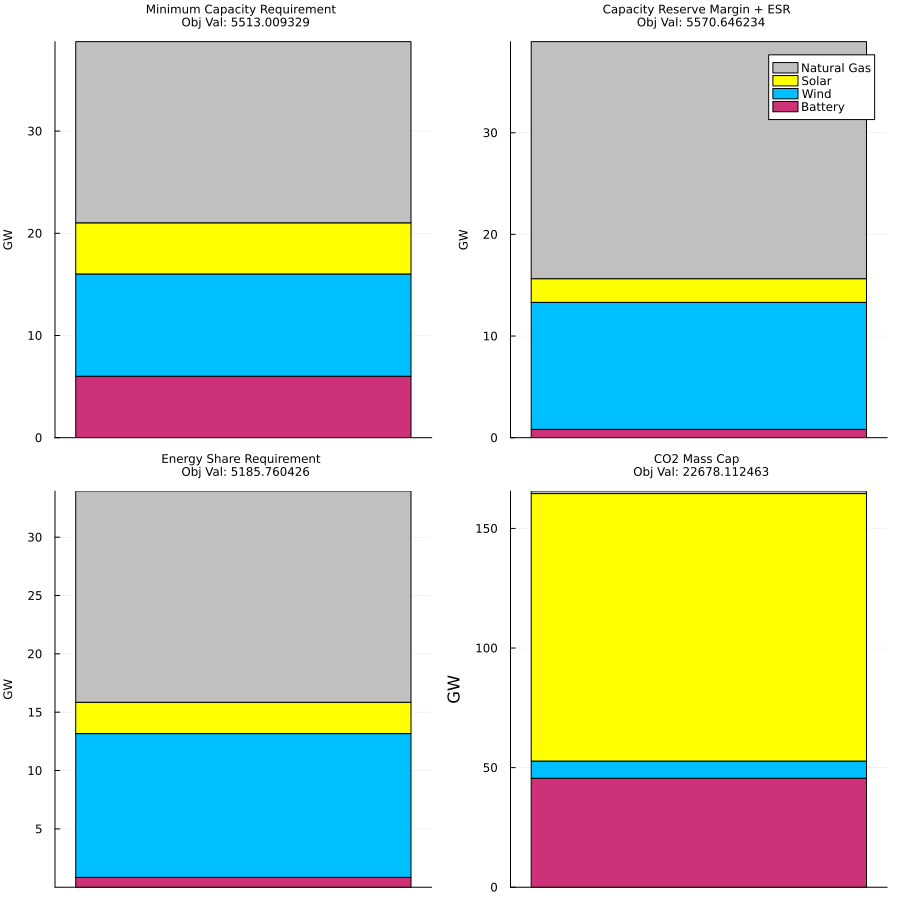

In [60]:
totCap9 = value.(EP9[:eTotalCap])

totCapB9 = [totCap9[1] + totCap9[2] + totCap9[3], totCap9[4] + totCap9[6], 
    totCap9[5] + totCap9[7], totCap9[8] + totCap9[9] + totCap9[10]]

println(DataFrame([RT totCap9],["Resource Type","Total Capacity"]))
println(" ")

G9 = groupedbar(transpose(totCapB9), bar_position = :stack, bar_width=.7,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],legend=false,color=colors,
        title="Minimum Capacity Requirement \n Obj Val: $(round(objective_value(EP9),digits=6))",ylabelfontsize=8)

plot(G9,G8,G7,G2,size=(900,900), titlefontsize=8,layout=(2,2))

## All Together <a id="All"></a>

`1_three_zones` has defaults of `CO2Cap = 2` and `MinCapReq = 1`. To see how everything comes together, let's add ESR and CRM in as well:

In [53]:
setup["MinCapReq"] = 1
setup["CO2Cap"] = 2
setup["EnergyShareRequirement"] = 1
setup["CapacityReserveMargin"] = 1;

In [54]:
inputs = GenX.load_inputs(setup, case)
EP10 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP10,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Capacity_reserve_margin.csv Successfully Read!
Minimum_capacity_requirement.csv Successfully Read!
Energy_share_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From example_systems/1_three_zones
Discharge Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Energy Share Requirement Policies Module
Capacity Reserve Margin Policies Module
Minimum Capacity Requirement Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
131076 rows, 97815 cols, 583119 nonzeros
123880 rows, 90620 cols, 586301 nonzeros
Presolve : Reductions: rows 123880(-42456); columns 90620(-46151); elements 586301(-49145)
Solving the presolved LP
IPX model has 123880 rows, 90620 columns and 586301 nonzeros
Input
    Number of variables:                                90620
    Number of free variables:                           3696
    Number of cons

(A JuMP Model
Minimization problem with:
Variables: 136771
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 40656 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 27728 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97952 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 133071 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cCO2Emissions_systemwide, cCapacityResMargin, cESRShare, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSOCMinCapRes, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, cVSoC

10×2 DataFrame
 Row │ Resource Type                  Total Capacity 
     │ Any                            Any            
─────┼───────────────────────────────────────────────
   1 │ MA_natural_gas_combined_cycle  7.82613
   2 │ CT_natural_gas_combined_cycle  5.92385
   3 │ ME_natural_gas_combined_cycle  0.643446
   4 │ MA_solar_pv                    17.3029
   5 │ CT_onshore_wind                15.8583
   6 │ CT_solar_pv                    13.8062
   7 │ ME_onshore_wind                11.735
   8 │ MA_battery                     2.70912
   9 │ CT_battery                     6.13452
  10 │ ME_battery                     1.33376
 


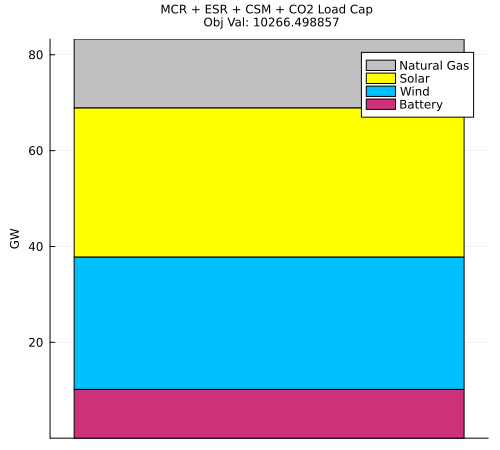

In [58]:
totCap10 = value.(EP10[:eTotalCap])

totCapB10 = [totCap10[1] + totCap10[2] + totCap10[3], totCap10[4] + totCap10[6], 
    totCap10[5] + totCap10[7], totCap10[8] + totCap10[9] + totCap10[10]]

println(DataFrame([RT totCap10],["Resource Type","Total Capacity"]))
println(" ")

G10 = groupedbar(transpose(totCapB10), bar_position = :stack, bar_width=.7,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],color=colors,
        title="MCR + ESR + CSM + CO2 Load Cap \n Obj Val: $(round(objective_value(EP10),digits=6))",ylabelfontsize=8)

plot(G10, titlefontsize=8)